In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

#connect the google drive to download and upload data
from google.colab import drive
drive.mount('/content/drive')
#set the path to the drive data folder
directoryTrain = '/content/drive/MyDrive/MLFall2022/CurrentProject/data'
#directoryTest = '/content/drive/MyDrive/MLFall2022/CurrentProject/dataRF/test/'

Mounted at /content/drive


In [2]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

<xarray.Dataset>
Dimensions:   (X: 155, Y: 208, time: 216)
Coordinates:
  * X         (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y         (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time      (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2001-12-15
Data variables:
    burnarea  (time, Y, X) float32 ...
<xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 216)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time     (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2001-12-15
Data variables:
    tmax     (time, Y, X) float32 ...
<xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 216)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time     (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2001-12-15
Da

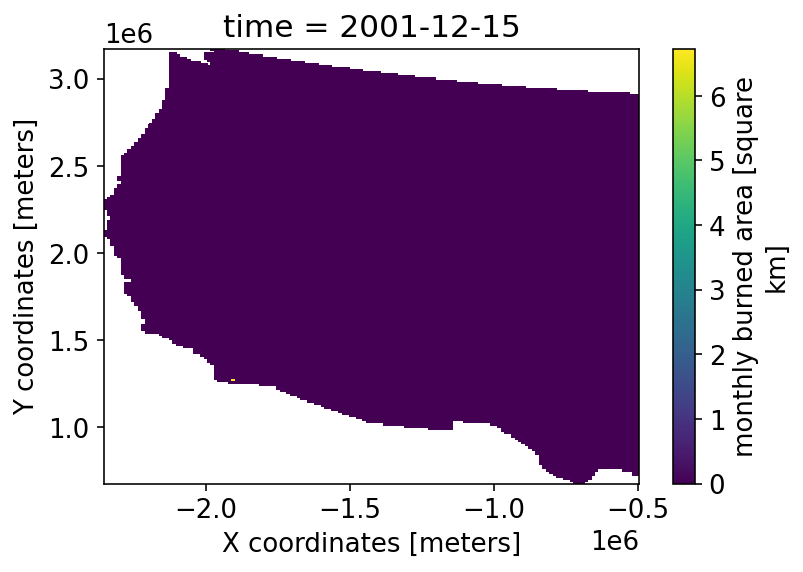

In [3]:
burnarea_combined = xr.open_dataset(os.path.join(directoryTrain, "burnarea_combined.nc"))
#print(burnarea_combined)

#data = xr.open_dataset(os.path.join(directoryTrain, "forest_type_frac.nc"))
#print(data.dims)

#data = xr.open_dataset(os.path.join(directoryTrain, "epa_level2.nc"))
#print(data.dims)

tmax = xr.open_dataset(os.path.join(directoryTrain, "tmax.nc"))
#print(tmax.dims)

prec = xr.open_dataset(os.path.join(directoryTrain, "prec.nc"))
#print(prec.dims)

wind = xr.open_dataset(os.path.join(directoryTrain, "wind.nc"))
#print(wind.dims)

##data = xr.open_dataset(os.path.join(directoryTrain, "elevstd.nc"))
#print(data.dims)

#data = xr.open_dataset(os.path.join(directoryTrain, "wui_distance.nc"))
#print(data.dims)

#burnarea_combined = burnarea_combined.burnarea.loc[firsttime:finaltime]
#print(burnarea_combined.dims)

air = burnarea_combined["burnarea"]
air.isel(time=215).plot(x="X", y="Y")

firsttime = "1984-01-15"
middletime = "2001-12-15"
middelstarttime = "2002-01-15"
finaltime = "2019-12-15"

#gotta split the data to train and test before merging and stacking

#print(burnarea_combined.burnarea["time"].isel(time = "2019-12-15"))
#print(burnarea_combined.time[431])

#TRAIN SLICES
burnarea_combined_train = burnarea_combined.sel(time=slice(firsttime, middletime))
print(burnarea_combined_train)

tmax_train = tmax.sel(time=slice(firsttime, middletime))
print(tmax_train)

prec_train = prec.sel(time=slice(firsttime, middletime))
print(prec_train)

wind_train = wind.sel(time=slice(firsttime, middletime))
print(wind_train)

#TEST SLICES
burnarea_combined_test = burnarea_combined.sel(time=slice(middelstarttime, finaltime))
print(burnarea_combined_test)

tmax_test = tmax.sel(time=slice(middelstarttime, finaltime))
print(tmax_test)

prec_test = prec.sel(time=slice(middelstarttime, finaltime))
print(prec_test)

wind_test = wind.sel(time=slice(middelstarttime, finaltime))
print(wind_test)


In [4]:
### LAT = X and LONG = Y 

# Training set
train_files = [burnarea_combined_train, tmax_train, prec_train, wind_train]
#X_train_xr, X_length  = prepare_predictor(train_files)
 
X_all      = []
length_all = []
    
for ds in train_files:
  X_all.append(ds)
  length_all.append(len(ds.time))

#print(X_all)
    
X = xr.merge(X_all)
length_all = np.array(length_all)

X = X.assign_coords(time=np.arange(len(X.time)))

X_train_xr = X
X_length = length_all

print(X_train_xr)

#y_train_xr, y_length  = prepare_predictand(train_files,directoryTrain)

Y_all = []
length_all = []
    
for dsy in train_files:
  Y_all.append(dsy)
  length_all.append(len(dsy.time))
    
length_all = np.array(length_all)
Y = xr.merge(Y_all)
Y = Y.rename({'Y':'longitude','X': 'latitude'})
Y = Y.transpose('time', 'latitude', 'longitude') 
  
Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
y_train_xr = Y 
y_length = length_all

<xarray.Dataset>
Dimensions:   (X: 155, Y: 208, time: 216)
Coordinates:
  * X         (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y         (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
Data variables:
    burnarea  (time, Y, X) float32 ...
    tmax      (time, Y, X) float32 ...
    prec      (time, Y, X) float32 ...
    wind      (time, Y, X) float32 ...


In [6]:
# Test set
#X_test_xr, _ = prepare_predictor('ssp245', data_path=directoryTest,time_reindex=False)
#y_test_xr, _ = prepare_predictand('ssp245',data_path=directoryTest,time_reindex=False)

# Train set
train_files = [burnarea_combined_test, tmax_test, prec_test, wind_test]
#X_train_xr, X_length  = prepare_predictor(train_files)
 
X_all      = []
length_all = []
    
for ds in train_files:
  X_all.append(ds)
  length_all.append(len(ds.time))

#print(X_all)
    
X = xr.merge(X_all)
length_all = np.array(length_all)

#NEED TO HAVE A DIFF ORDER OF DIMENSIONS 
#time, Y, X 
X = X[['time', 'Y', 'X', 'burnarea', 'tmax', 'prec', 'wind' ]] #not what we need, we need to change the shape 

X = X.assign_coords(time=np.arange(len(X.time)))

X_test_xr = X
X_length = length_all

print(X_test_xr)

#y_train_xr, y_length  = prepare_predictand(train_files,directoryTrain)

Y_all = []
length_all = []
    
for dsy in train_files:
  Y_all.append(dsy)
  length_all.append(len(dsy.time))
    
length_all = np.array(length_all)
Y = xr.merge(Y_all)
Y = Y.rename({'Y':'longitude','X': 'latitude'})
Y = Y.transpose('time', 'latitude', 'longitude') 
  
Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
y_test_xr = Y 
y_length = length_all

print(y_test_xr)

<xarray.Dataset>
Dimensions:   (time: 216, Y: 208, X: 155)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
  * Y         (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * X         (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
Data variables:
    burnarea  (time, Y, X) float32 ...
    tmax      (time, Y, X) float32 ...
    prec      (time, Y, X) float32 ...
    wind      (time, Y, X) float32 ...
<xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    burnarea   (time, latitude, longitude) float32 ...
    tmax       (time, latitude, longitude) float32 ...
    prec       (time, latitude, longitude) float32 ...
    wind       (time, 

In [7]:
X_train_df = X_train_xr.to_dataframe().dropna()

X_test_df  = X_test_xr.to_dataframe().dropna()

print(y_train_xr)
print("pass\n")

y_train_df = y_train_xr.stack(dim=["latitude", "longitude"])
print(y_train_df)
print("pass\n")

y_train_df = y_train_df.to_dataframe().dropna()
print(y_train_df)
print("pass")


<xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    burnarea   (time, latitude, longitude) float32 ...
    tmax       (time, latitude, longitude) float32 ...
    prec       (time, latitude, longitude) float32 ...
    wind       (time, latitude, longitude) float32 ...
pass

<xarray.Dataset>
Dimensions:    (time: 216, dim: 32240)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
  * dim        (dim) object MultiIndex
  * latitude   (dim) float64 -2.349e+06 -2.349e+06 ... -5.012e+05 -5.012e+05
  * longitude  (dim) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
Data variables:
    burnarea   (time, dim) float32 nan nan nan nan nan ... 0.0 nan nan nan nan
    tma

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(5167152, 4) (5167152, 6) (5167152, 4)


In [9]:
n_estimators      = 5      # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'auto' # Number of features to consider at every split
max_depth         = 25     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(X_train,y_train)

#number of estimators 100 ran for 1:10+ hours 
#number of estimators 40 ran for long as well 
#number lowered to 5 also ran very long time, meaning we need to fix the data, but it did finsih running with GPU 

In [ ]:
#in the exmaple code, the regressor particularly improves the code, after running it 3 times, with improved parameters, 
#the results and accuracy have been improved. The final at the moment parameters were set to: 
#n_estimators      = 300    
#min_samples_split = 25     
#min_samples_leaf  = 4      
#max_features      = 'sqrt' 
#max_depth         = 20     
#bootstrap         = True   

In [10]:
### EXTRA SOURCE ###
#https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb#scrollTo=qZyMvAQp6iwB
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

#https://medium.com/rapids-ai/accelerating-random-forests-up-to-45x-using-cuml-dfb782a31bea
from cuml import RandomForestClassifier as cuRF     

# cuml Random Forest params   
cu_rf_params = (n_estimators == 25, max_depth == 13, n_bins == 15, n_streams == 8)             
cu_rf = cuRF(**cu_rf_params)     
cu_rf.fit(X_train, y_train)      
                                                                       
print("cuml RF Accuracy Score: ", accuracy_score(cu_rf.predict(X_test), y_test))


--2023-01-17 17:46:46--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2023-01-17 17:46:46--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  95.0MB/s    in 0.6s    

2023-01-17 17:46:47 (95.0 MB/s) - ‘Miniconda3-4.5.4-Linux-x86

FileNotFoundError: ignored

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [12]:
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [13]:
###DID NOT FINISH RUNNING, TOBEFIXED###
reg0 = RandomForestRegressor(random_state=0)
#perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, 
                                param_distributions = random_grid, 
                                n_iter = 5, 
                                cv = 3, 
                                verbose=2, 
                                n_jobs = -1)

rf_tas = rf_random0.fit(X_train,y_train)

#was running for a very long time, did not run 

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: ignored

In [14]:
### CONTINUE FIX HERE ### 
print(X_test.shape)
y_test_pre = rf_tas.predict(X_test)
print(y_test_pre.shape)
y_test_pre = y_test_pre.reshape(31002912, 155, 208)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                        data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

(5167152, 4)
(5167152, 6)


ValueError: ignored

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()